In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np
import om4labs

In [4]:
# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [41]:
ds_obs = xr.open_dataset("/work/Katherine.Turner/SOTC/mld_dr003_ref10m_v2023.nc", use_cftime=True)

path_hist = "/work/Katherine.Turner/tempest-extremes/CM4_historical/"
ds_mld = xr.open_mfdataset(f"{path_hist}/mld/*MLD_003.nc", use_cftime=True)

lon_name = 'lon'  # whatever name is in the data

# Adjust lon values to make sure they are within (-180, 180)
ds_mld['_longitude_adjusted'] = xr.where(
    ds_mld[lon_name] > 180,
    ds_mld[lon_name] - 360,
    ds_mld[lon_name])

# reassign the new coords to as the main lon coords
# and sort DataArray using new coordinate values
ds = (
    ds_mld
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(ds_mld._longitude_adjusted)})
    .drop(lon_name))

ds = ds.rename({'_longitude_adjusted': lon_name})

In [42]:
mld_season = ds.MLD_003.groupby(ds_mld.time.dt.season).mean()

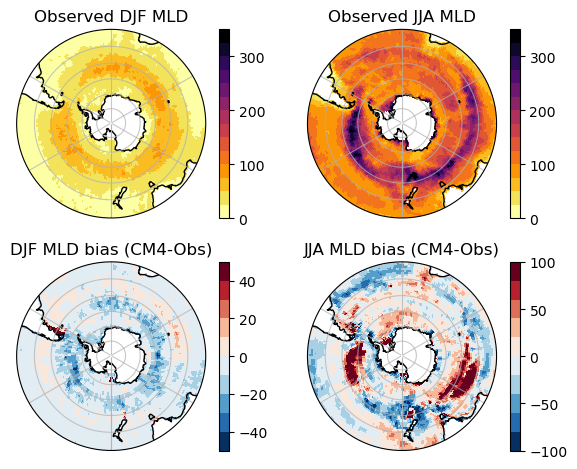

In [51]:
titles = ["Observed DJF MLD", "Observed JJA MLD", "DJF MLD bias (CM4-Obs)", "JJA MLD bias (CM4-Obs)"]

fig, a = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection':ccrs.SouthPolarStereo()})
a = a.flatten()

f = ds_obs.mld_dr003.sel(time=[14, 45, 348]).mean(dim="time").plot(ax=a[0], transform=ccrs.PlateCarree(), 
                                                                   vmin=0, vmax=350, 
                                                                   cmap=plt.get_cmap("inferno_r", 14), 
                                                                   add_colorbar=False)
plt.colorbar(f, ax=a[0], aspect=20, fraction = .05)

f = ds_obs.mld_dr003[5:8].mean(dim="time").plot(ax=a[1], transform=ccrs.PlateCarree(), 
                                                                   vmin=0, vmax=350, 
                                                                   cmap=plt.get_cmap("inferno_r", 14), 
                                                                   add_colorbar=False)
plt.colorbar(f, ax=a[1], aspect=20, fraction = .05)


f = (mld_season[0,:,:] - ds_obs.mld_dr003.sel(time=[14, 45, 348]).mean(dim="time")).plot(ax=a[2], transform=ccrs.PlateCarree(), 
                                                                   vmin=-50, vmax=50, 
                                                                   cmap=plt.get_cmap("RdBu_r", 10), 
                                                                   add_colorbar=False)
plt.colorbar(f, ax=a[2], aspect=20, fraction = .05)


f = (mld_season[1,:,:] - ds_obs.mld_dr003[5:8,:,:].mean(dim="time")).plot(ax=a[3], transform=ccrs.PlateCarree(), 
                                                                   vmin=-100, vmax=100, 
                                                                   cmap=plt.get_cmap("RdBu_r", 10), 
                                                                   add_colorbar=False)
plt.colorbar(f, ax=a[3], aspect=20, fraction = .05)

for i in np.arange(4):
    a[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    a[i].gridlines(alpha=0.7)
    a[i].set_boundary(circle, transform=a[i].transAxes)
    a[i].coastlines()
    a[i].set_title(f"{titles[i]}")
plt.tight_layout()
plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/MLD_bias.png", dpi=100, format="png", bbox_inches="tight")